In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# deeptrack.features

This example introduces the module deeptrack.features.

## 1. What is a feature?

Features are instances of the abstract class `Feature` and are responsible for creating and altering images. For example, a feature might add a particle or add some salt-and-pepper noise to an image.

All features operate on lists of images. Most features, such as noise, apply some tranformation to all images in the list. This transformation can be additive, such as adding some Gaussian noise or a background illumination, or non-additive, such as introducing Poisson noise or performing a low-pass filter. This transformation is defined by the method `get(image, **kwargs)`, which all implementations of the class `Feature` need to define.

Some features, for example scattterers, instead, append a new image to the list. This behavior is controlled by the class attributes `__distributed__` and `__list_merge_strategy__`:
* `__distributed__` controls whether `.get(image, **kwargs)` is called on each element in the list separately (`__distributed__ = True`), or it is called on the list as a whole (`__distributed__ = False`).  
* `__list_merge_strategy__` controls how the output of `.get(image, **kwargs)` is merged with the input list. It can be `MERGE_STRATEGY_OVERRIDE` (0, default), where the new list is output without merging with the input, or `MERGE_STRATEGY_APPEND` (1), where the new list is appended to the end of the input list.

When a feature is created, keyword arguments can be passed to its constructor. These arguments are stored as properties (as a `PropertyDict`) of the feature (see also [properties_example](properties_example.ipynb)), which determine how the feature is resolved. When a feature is updated using the method `.update()`, all properties are updated by calling their respective methods `.update()`. When a feature is resolved using the method `resolve(image)`, the current values of all properties are sent through the method `get(image, **kwargs)` as keyword arguments.

In [2]:
import numpy as np
from deeptrack.features import Feature

# Implementation of abstract class Feature 
# which does not alter the input image 
# and prints the current value of my_property
class Foo(Feature):

    # Controls what is passed to the method get(): 
    # False: everything is passed without modification.
    # True: elements along the first axis are passed separately.
    __distributed__ = False

    def get(self, image, my_property=None, **kwargs):
        print("The current value of my_property is", my_property)
        return image



foo1 = Foo(my_property=1)
foo1.update()
output_image = foo1.resolve()

foo2 = Foo(my_property="bar")
foo2.update()
output_image = foo2.resolve()

foo3 = Foo()
foo3.update()
output_image = foo3.resolve()

The current value of my_property is 1
The current value of my_property is bar
The current value of my_property is None


Since the values are stored as instances of the class `Property`, we can always replace values with standard structures (e.g., lists or lambda functions) to create more complex behaviors (see also [properties_example](properties_example.ipynb)).

In [3]:
foo4 = Foo(my_property=lambda: np.random.rand() - 0.5)
foo4.update()
output_image = foo4.resolve()

foo5 = Foo(my_property=lambda: np.random.choice(["bar", "baz"])) # picks one random element from the list
foo5.update()
output_image = foo5.resolve()

The current value of my_property is -0.03983018996061671
The current value of my_property is bar


## 2. Operations defined on features

Features can be combined to create a feature series, which is a series of features that are evaluated sequentially. This is done using the add operator (+), the multiply operator (\*), and the power operator (\*\*).

### Adding features (+)

The add operator (+) combines two features such that they are evaluated sequentially. For example, given the features `foo` and `bar`, we can combine them as `foobar = foo + bar`. When `foobar` resolves an image, it first resolves an image from `foo`, then uses this image as the input to resolve an image from `bar`.

This operation returns an instance of the feature `Branch`, which contains the two features.

In [4]:
foobar = Foo(my_property="foo") + Foo(my_property="bar")

foobar.update()
output_image = foobar.resolve()

The current value of my_property is foo
The current value of my_property is bar


### Multiplying a feature by a number (\*)

Multiplying a feature `foo` by a number `p` creates a new feature that has a probability `p` of resolving the feature `foo`, and a probability `1-p` to return the input image without modifying it.

This operation returns an instance of the feature `Probability`, which contains the feature and the probability to resolve the feature.

In [5]:
foo = Foo(my_property=0) * 0.5

foo.update()
output_image = foo.resolve() # if the feature is not resolved, nothing is printed

And now a more complex example combining addition and multiplication.

In [6]:
foo = Foo(my_property=0) * 0.5
for i in range(1, 10):
    foo = foo + Foo(my_property=i) * 0.5
# foo is now 10 instances of Foo, each with a 50% chance of being resolved

foo.update()
output_image = foo.resolve()

The current value of my_property is 1
The current value of my_property is 2
The current value of my_property is 5
The current value of my_property is 6
The current value of my_property is 9


### Exponentiating feature to integer (\*\*)

The power operator (\*\*) takes a feature `foo` and an integer `i` and creates `i` deep copies of the feature, which are added to the feature series at resolve time. For example, `foo**5` will create 5 deep copies of the instance of Foo and add them to the feature series. Since this is done at resolve time, the exponent can be any expression that returns an integer when evaluated.

This operation returns an instance of the feature `Duplicate`, which contains the original feature and the number of times it should be duplicated.

In [7]:
foo = Foo(my_property=lambda: np.random.choice(["bar", "baz", "qux", "quux"])) 

five_foos = foo**5
five_foos.update()
output_image = five_foos.resolve()

The current value of my_property is quux
The current value of my_property is quux
The current value of my_property is bar
The current value of my_property is baz
The current value of my_property is qux


In [8]:
number_of_foo = lambda: np.random.randint(0, 10)

random_foos = foo**number_of_foo
random_foos.update()
output_image = random_foos.resolve() # picks one random exponent from the list

The current value of my_property is baz
The current value of my_property is baz


## 3. Example - Image with random circles

Simple example that generates an image with some random circles.

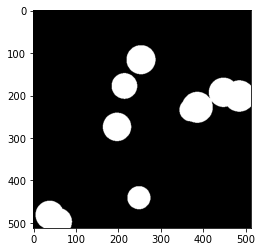

In [9]:
from matplotlib import pyplot as plt

# Implementation of the abstract class Feature that draws a circle on an image.
class Circle(Feature):

    def get(self, image, position, radius, intensity, **kwargs):
        X, Y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
        mask = (X - position[0])**2 + (Y - position[1])**2 < radius**2
        image[mask] = intensity
        return image

circle = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1
)

input_image = np.zeros((512, 512))
circles = circle**10
circles.update()
output_image = circles.resolve(input_image) 

from matplotlib import pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.show()

## 4. Example - Image with stacked circles

And now a more complex example. In this case, we have a feature that depends on another feature. In such cases, due to the way features are updated, we can only reliably depend on features that are resolved earlier in the sequence. 

For example, this issue emerges when using the feature `Duplicate` (i.e., the \*\* operator) to create deep copies of an original feature. For example, consider `C = (A + B)**3`. This operation will produce three copies of A (A1, A2, A3), and three copies of B (B1, B2, B3). If B depends on A, then (B1, B2, B3) will also depend on A, not on (A1, A2, A3) as one might expect. 

We can work around this problem using a for-loop instead of the  \*\* operator.

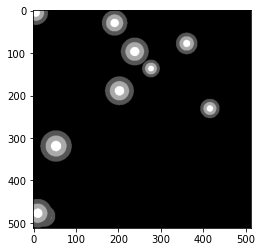

In [10]:


# We introduce wrapped functions to be used instead of lambda functions.
def get_position(base):
    def func():
        return base.properties["position"].current_value
    return func

def get_radius(base, multiplication_factor):
    def func():
        return base.properties["radius"].current_value * multiplication_factor
    return func

# Since 'circle2' and `circle3` reference 'circle1', 
# we can't use the ** syntax to duplicate the feature. 
# Instead, we use a for-loop.
for i in range(10):
    
    circle1 = Circle(
        position=lambda: np.random.rand(2) * 512,
        radius=lambda: 20 + np.random.rand() * 20,
        intensity=1
    )
   
    circle2 = Circle(
        position=get_position(circle1),
        radius=get_radius(circle1, 0.67),
        intensity=2
    )

    circle3 = Circle(
        position=get_position(circle1),
        radius=get_radius(circle1, 0.33),
        intensity=3
    )
    
    stacked_circles = circle1 + circle2 + circle3
    
    if i == 0:
        features = stacked_circles
    else: 
        features = features + stacked_circles
        
input_image = np.zeros((512, 512))
output_image = features.resolve(input_image) 

plt.imshow(output_image, cmap='gray')
plt.show()

## 5. Example - Image with power-operator-friendly stacked circles 

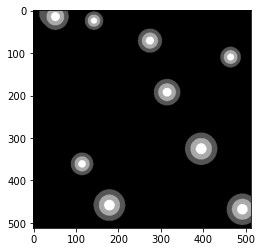

In [11]:
from deeptrack.properties import Property

position_property = Property(lambda: np.random.rand(2) * 512)
radius_property = Property(lambda: 20 + np.random.rand() * 20)
    
circle1 = Circle(
    position=position_property,
    radius=radius_property,
    intensity=1
)

circle2 = Circle(
    position=position_property,
    base_radius=radius_property,
    radius=lambda base_radius: base_radius * 2 / 3,
    intensity=2
)

circle3 = Circle(
    position=position_property,
    base_radius = radius_property,
    radius=lambda base_radius: base_radius * 1 / 3,
    intensity=3
)

stacked_circles = (circle1 + circle2 + circle3) ** 10
stacked_circles.update()
input_image = np.zeros((512, 512))
output_image = stacked_circles.resolve(input_image) 

plt.imshow(output_image, cmap='gray')
plt.show()